# Pyro Hierarchical Forecast with "Exposure" Covariate

Use case is that we have several individuals, some exposed to a factor relevant to the forecast target (e.g. intervention) and others individuals without exposure. We model this simply as an additive effect to our target. More complex effects could be modeled by alternative effects vectors that account for things like history, thresholds, saturations, etc. 

Here we synthesize data to see how well we can recover knowing the ground truth. 

This example primary uses the Pyro Hierarchichal Forecast (III) example [here](http://pyro.ai/examples/forecasting_iii.html), and shows how to add an additional covariate vector such as in an exposed/not-exposed clinical data set. 

Other notes

Stock code allows for season with shared period but variable amplitude across people.

>TODO 

>Add trend - there is no global trend inference; can also detrend prior to fitting using a variety of methods

>Multiple seasons - for now can add as additional covariate

>Hyperprior on season period 

>Variable amplitude for exposure effect across people.

>Missing data - for now impute

>Assumes common start date- unrealistic, for now use some relative t0, though if season (like winter vs summer matters) then need to account for this


## Load libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
# from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps, backtest
from pyro.infer.reparam import LocScaleReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile

assert pyro.__version__.startswith('1.8.0')
pyro.set_rng_seed(20200305)


### Our modified forecast model

In [2]:
class Model(ForecastingModel):
    def model(self, zero_data, covariates):
        duration, data_dim = zero_data.shape
        feature = covariates
        weight = pyro.sample("weight", dist.Normal(0, 1))
       
        # Let's model each time series as a Levy stable process, and share process parameters
        # across time series. To do that in Pyro, we'll declare the shared random variables
        # outside of the "origin" plate:
        drift_stability = pyro.sample("drift_stability", dist.Uniform(1, 2))
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5))
        with pyro.plate("origin", data_dim, dim=-2):
            # Now inside of the origin plate we sample drift and seasonal components.
            # All the time series inside the "origin" plate are independent,
            # given the drift parameters above.
            with self.time_plate:
                # We combine two different reparameterizers: the inner SymmetricStableReparam
                # is needed for the Stable site, and the outer LocScaleReparam is optional but
                # appears to improve inference.
                with poutine.reparam(config={"drift": LocScaleReparam()}):
                    with poutine.reparam(config={"drift": SymmetricStableReparam()}):
                        drift = pyro.sample("drift",
                                            dist.Stable(drift_stability, 0, drift_scale))

            with pyro.plate("hour_of_day", 24 , dim=-1):
                seasonal = pyro.sample("seasonal", dist.Normal(0, 5))

            ## working on patient specific exposure parameters - like Levy (sample some global hyperparameters)
            # with pyro.plate("exposure", 1, dim=-1):
            #     regressor = pyro.sample("weight", dist.Normal(0, 0.1))#.expand([duration]).to_event(1))

        # Now outside of the time plate we can perform time-dependent operations like
        # integrating over time. This allows us to create a motion with slow drift.
        
        seasonal = periodic_repeat(seasonal, duration, dim=-1)
        ## need to review this - Levy == OU, which we used to add noise to system
        ## if drift is the velocity at time t, then cumsum is giving the displacement from t0
        motion = drift.cumsum(dim=-1)  # A Levy stable motion to model shocks.
        
        regressor = (weight*feature.T)

        prediction =  regressor + motion + seasonal
        
        # Next we do some reshaping. Pyro's forecasting framework assumes all data is
        # multivariate of shape (duration, data_dim), but the above code uses an "origins"
        # plate that is left of the time_plate. Our prediction starts off with shape
        assert prediction.shape[-2:] == (data_dim, duration)
        # We need to swap those dimensions but keep the -2 dimension intact, in case Pyro
        # adds sample dimensions to the left of that.
        prediction = prediction.unsqueeze(-1).transpose(-1, -3)
        assert prediction.shape[-3:] == (1, duration, data_dim), prediction.shape

        # Finally we can construct a noise distribution.
        # We will share parameters across all time series.
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-5, 5))
        noise_dist = dist.Normal(0, obs_scale.unsqueeze(-1))
        self.predict(noise_dist, prediction)

## Synthesize some data 

Seasonal (periodic) plus OU noise plus "exposure" period for some regions. Define two groups, those with exposures and those without. Only difference within exposed group is start/stop of event periods. 

Exposures are some contiguous periods. They are modelled here as periodic square-waves with phase shifts across the exposed group. 

In [5]:
def OU(itot,tau=20,dt=1,mu=0,sigma=1):
  """
  Generate Ornstein-Uhlenbeck "noise"
  Generally use dt = tau/20. We'll keep tau large in units hours to avoid resampling OU vs our fake data.
  """
  z = np.zeros(itot)
  z[0] = mu
  for i in range(itot):
    z[i] = z[i-1] + dt * (-(z[i-1] - mu) / tau) + (2*dt/tau)**0.5 * sigma * np.random.randn()
  return z

### Define exposure effect size

In [ ]:
## define effect size of exposure
## in future should model this conditioned on prior exposure
## likely to be more realistic for biological systems 
ex_dose = 2

### Generate individuals 

In [6]:
## time unit is hours
ttot = 24*7*8 ## 24 hours/day x 7 days/weeks x W weeks
t = np.arange(0,ttot+1,1) ## closed observation window from [0,ttot]

## define OU parameters
sigma = 5e-1

## initialize "observed" dataframe
## make arbitrary datetime (typical time format of real data) - legacy for statsmodel SARIMAX
## here all records are aligned to a single date - unrealistic
## replace with some t0 across records
d0 = pd.to_datetime({'year':[1999],'month':[1],'day':[1],'hour':[0]})[0]
dt = pd.date_range(start=d0,periods=len(t),freq='1H')
df = pd.DataFrame()
df['datetime'] = dt
df.index = df.datetime

## initialize covariate dataframe
dfc = pd.DataFrame()
dfc['datetime'] = dt
dfc.index = dfc.datetime

## define size of groups
Nex = 5 ## number exposed
Nnex = 20 ## number not exposed



## first populate exposed
k = 0

for i in range(Nex):
    k += 1
    x1 = np.random.random()*np.cos(t/24*2*np.pi+np.pi) + 1
    x2 = 0*t*5e-3 ## add trend - 
    ## exposure trace - square wave in {0,1}
    ex = (((1*np.cos(1/(ttot/50)*t/24*2*np.pi+np.random.random()*np.pi)+1)>1.5).astype(int))
    z = OU(itot=len(t),sigma=sigma)
    df[f'val{i}'] = x1+ex_dose*ex+z+x2
    dfc[f'val{i}'] = ex
    
for i in range(k,k+Nnex):
    k += 1
    x1 = np.random.random()*np.cos(t/24*2*np.pi+np.pi) + 1
    x2 = 0*t*5e-3
    ex = 0*(((1*np.cos(1/(ttot/50)*t/24*2*np.pi+np.random.random()*np.pi)+1)>1.5).astype(int))
    z = OU(itot=len(t),tau=1,sigma=sigma)
    df[f'val{i}'] = x1+ex_dose*ex+z+x2
    dfc[f'val{i}'] = ex

fig = px.line(df,y=[f'val{i}' for i in range(k)])
fig.show()

data = torch.tensor(df.iloc[:,1:].values)
covariates = torch.tensor(dfc.iloc[:,1:].values)
# covariates = torch.zeros(len(data), 0)  # empty

T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 4  # train/test split
T0 = T1 - 24 * 7 * 4     # beginning: train on 90 days of data

print((T0,T1,T2))


(1, 673, 1345)


## Infer parameters

In [8]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
forecaster = Forecaster(Model(), data[T0:T1], covariates[T0:T1],
                        learning_rate=0.1, num_steps=501, log_every=50)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 2.2664e+07
INFO 	 step   50 loss = 736.966
INFO 	 step  100 loss = 9.43365
INFO 	 step  150 loss = 6.3655
INFO 	 step  200 loss = 4.4999
INFO 	 step  250 loss = 3.38947
INFO 	 step  300 loss = 2.72474
INFO 	 step  350 loss = 2.31932
INFO 	 step  400 loss = 2.05084
INFO 	 step  450 loss = 1.89812
INFO 	 step  500 loss = 1.78336


weight = 2.254
drift_stability = 1.004
drift_scale = 2.247e-07
obs_scale = 0.6811
CPU times: user 16.2 s, sys: 2.5 s, total: 18.7 s
Wall time: 18.7 s


## Forecast

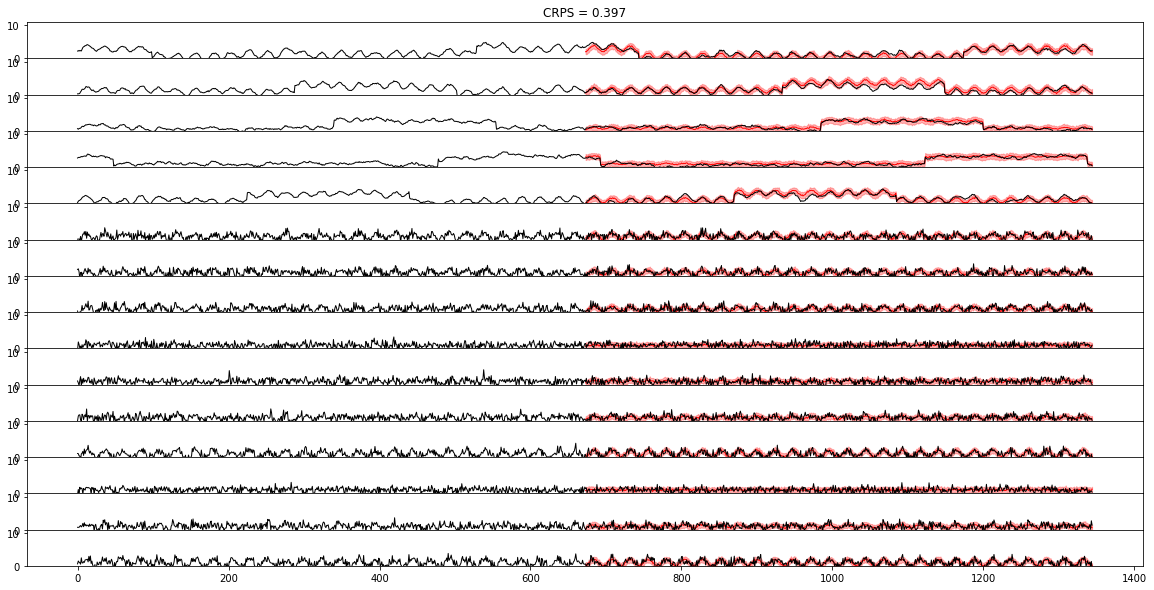

In [9]:
samples = forecaster(data[T0:T1], covariates[T0:T2], num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples[:, 0], (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:T2])
# print(samples.shape, p10.shape)

fig, axes = plt.subplots(15, 1, figsize=(20, 10), sharex=True)
plt.subplots_adjust(hspace=0)
axes[0].set_title("CRPS = {:0.3g}".format(crps))
for i, ax in enumerate(axes):
    # ax.axvline(78736, color="green", lw=20, alpha=0.2)
    ax.fill_between(torch.arange(T1, T2), p10[:, i], p90[:, i], color="red", alpha=0.3)
    ax.plot(torch.arange(T1, T2), p50[:, i], 'r-', lw=1, label='forecast')
    ax.plot(
            data[:, i], 'k-', lw=1, label='truth')
    ax.set_ylim(0,1+ex_dose*5)
#     ax.set_ylabel("from {}".format(dataset["stations"][i]))
# ax.set_xlabel("Hour after 2011-01-01")
# ax.text(78732, -3, "Christmas", color="green", horizontalalignment="center")
# ax.set_xlim(T1 - 24 * 7, T2)
# axes[0].legend(loc="best");

## Evaluation metrics

Continuous ranked probability score (CRPS) -
"The continuous ranked probability score (CRPS) is a much used measure of performance for probabilistic forecasts of a scalar observation. It is a quadratic measure of the difference between the forecast cumulative distribution function (CDF) and the empirical CDF of the observation."

ref: 

Zamo, M., & Naveau, P. (2018). Estimation of the continuous ranked probability score with limited information and applications to ensemble weather forecasts. Mathematical Geosciences, 50(2), 209-234.

Gneiting, T., & Raftery, A. E. (2007). Strictly proper scoring rules, prediction, and estimation. Journal of the American statistical Association, 102(477), 359-378.

## Backtesting

In [12]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows2 = backtest(data, covariates, Model,
                    min_train_window=100, test_window=50, stride=200,
                    forecaster_options={"learning_rate": 0.1, "time_reparam": "dct",
                                        "log_every": 1000, "warm_start": True})

INFO 	 Training on window [0:100], testing on window [100:150]
INFO 	 step    0 loss = 60127
INFO 	 step 1000 loss = 1.69573
INFO 	 Training on window [0:300], testing on window [300:350]
INFO 	 step    0 loss = 5.93717
INFO 	 step 1000 loss = 1.3872
INFO 	 Training on window [0:500], testing on window [500:550]
INFO 	 step    0 loss = 4.45298
INFO 	 step 1000 loss = 1.29079
INFO 	 Training on window [0:700], testing on window [700:750]
INFO 	 step    0 loss = 3.56081
INFO 	 step 1000 loss = 1.24316
INFO 	 Training on window [0:900], testing on window [900:950]
INFO 	 step    0 loss = 3.06481
INFO 	 step 1000 loss = 1.22438
INFO 	 Training on window [0:1100], testing on window [1100:1150]
INFO 	 step    0 loss = 2.64997
INFO 	 step 1000 loss = 1.1976


CPU times: user 4min 8s, sys: 29.4 s, total: 4min 37s
Wall time: 4min 29s


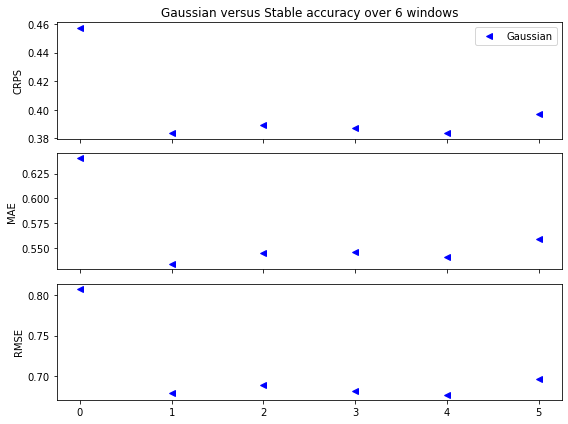

In [13]:
fig, axes = plt.subplots(3, figsize=(8, 6), sharex=True)
axes[0].set_title("Gaussian versus Stable accuracy over {} windows".format(len(windows2)))
axes[0].plot([w["crps"] for w in windows2], "b<", label="Gaussian")
# axes[0].plot([w["crps"] for w in windows3], "r>", label="Stable")
axes[0].set_ylabel("CRPS")
axes[1].plot([w["mae"] for w in windows2], "b<", label="Gaussian")
# axes[1].plot([w["mae"] for w in windows3], "r>", label="Stable")
axes[1].set_ylabel("MAE")
axes[2].plot([w["rmse"] for w in windows2], "b<", label="Gaussian")
# axes[2].plot([w["rmse"] for w in windows3], "r>", label="Stable")
axes[2].set_ylabel("RMSE")
axes[0].legend(loc="best")
plt.tight_layout()